# Assembling data for the Hyades

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
def convert_hours_to_degrees(df, ra_name, dec_name):
    RA, DE = [], [] #[np.zeros(len(douglas)) for i in range(2)]
    for i in range(len(df)):     
        coords = "{0} {1}".format(df[ra_name].values[i], df[dec_name].values[i])
        c = SkyCoord(coords, unit=(u.hourangle, u.deg))
        RA.append(c.ra.degree)
        DE.append(c.dec.degree)
    df["ra"] = RA
    df["dec"] = DE
    return df

Combine Douglas, Delorme and Radick (still need to add Hartman, Prosser and ASAS).

In [5]:
douglas = pd.read_csv("../data/hyades.csv")
delorme = pd.read_csv("../data/hyades_delorme.csv", skiprows=70)
radick87= pd.read_csv("../data/hyades_radick_1987.csv")
radick95= pd.read_csv("../data/hyades_radick_1995.csv")
hartman = pd.read_csv("../data/hartman.csv", skiprows=76)

hartman = convert_hours_to_degrees(hartman, "RAJ2000", "DEJ2000")

radick87.head()

,number,B-V,period,period_err,RAJ1950,decJ1950
0,VB 65,0.535,5.87,0.03,4 24 45,15 28 43
1,VB 59,0.543,5.13,0.02,4 23 15,15 24 44
2,VB 31,0.566,5.45,0.02,4 17 18,19 6 54
3,VB 52,0.597,8.05,0.06,4 21 36,16 46 19
4,VB 50,0.601,7.10,0.05,4 21 22,14 38 38


In [8]:
from astropy.coordinates import FK5

RAJ2000, DEJ2000 = [], []
for i in range(len(radick87)):
    coord = SkyCoord(radick87.RAJ1950.values[i], radick87.decJ1950.values[i], 
                     unit=(u.hourangle, u.deg), equinox="J1950")
    rd = coord.transform_to(FK5(equinox='J2000'))
    RAJ2000.append(rd.ra.degree)
    DEJ2000.append(rd.dec.degree)

radick87["RAJ2000"] = np.array(RAJ2000)
radick87["DEJ2000"] = np.array(DEJ2000)

Load the gaia crossmatch for the clusters.

In [9]:
gaia = pd.read_csv("../data/gaia_cluster_crossmatch.csv", skiprows=49)
m = gaia.Cluster.values == "Hyades  "
hg = gaia.iloc[m]
hg.head()

,Source,Cluster,RA_ICRS,DE_ICRS,Gmag,plx,e_plx,_RA.icrs,_DE.icrs
0,49520255665123328,Hyades,64.87461,21.75372,12.861,20.866,0.033,64.87461,21.75372
1,49729231594420096,Hyades,60.20378,18.19388,5.790,21.789,0.045,60.20378,18.19388
2,51383893515451392,Hyades,59.80696,20.42805,12.570,22.737,0.006,59.80696,20.42805
3,145373377272257664,Hyades,66.06127,21.73605,6.990,23.109,0.003,66.06127,21.73605
4,145391484855481344,Hyades,67.00371,21.61972,5.643,19.968,0.067,67.00371,21.61972


And Megan Bedell's K2 - Gaia crossmatch.

In [10]:
bedell = pd.read_csv("K2_c4_gaia.csv")

In [11]:
m = min(douglas.ra.values) - .1 < bedell.ra.values
m &= bedell.ra.values < max(douglas.ra.values) + .1
m &= min(douglas.dec.values) - .1 < bedell.dec.values
m &= bedell.dec.values < max(douglas.dec.values) + .1
b = bedell.iloc[m]

Do the crossmatch between Douglas and Bedell.

In [281]:
print(bedell.keys())
douglas_gaia = pd.merge(douglas, bedell, left_on="EPIC", right_on="epic_number")

Index(['designation', 'source_id', 'gaia_ref_epoch', 'ra', 'ra_error', 'dec',
       'dec_error', 'parallax', 'parallax_error', 'parallax_over_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_primary_flag',
       'duplicated_source', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
       'phot_bp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error',
       'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'radial_velocity',
       'radial_velocity_error', 'phot_variable_flag', 'l', 'b', 'ecl_lon',
       'ecl_lat', 'teff_val', 'teff_percentile_lower', 'teff_percentile_upper',
       'a_g_v

ValueError: Big-endian buffer not supported on little-endian compiler

(-1, 36)

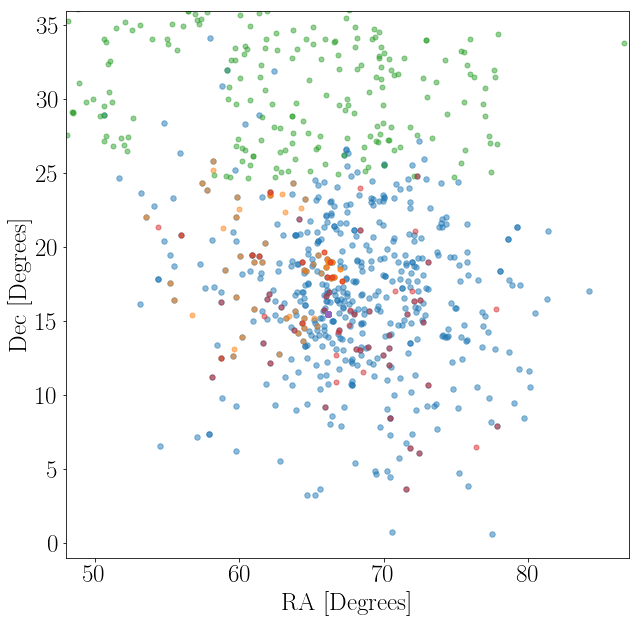

In [135]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(douglas.ra, douglas.dec, s=25, zorder=1, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=2, alpha=.5)
plt.scatter(delorme._RA, delorme._DE, s=25, zorder=3, alpha=.5)
plt.scatter(radick87.RAJ2000, radick87.DEJ2000, zorder=4, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find closest matches between Gaia and other catalogues.

In [265]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    closest_ra, closest_dec, distance = [], [], []
    for i in range(len(ra1)):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        m = e2 == min(e2)
        if sum(m) > 1:
            closest_ra.append(ra2.values[m][0])
            closest_dec.append(dec2.values[m][0])
            distance.append(e2[m][0])
        else:
            closest_ra.append(float(ra2.values[m]))
            closest_dec.append(float(dec2.values[m]))
            distance.append(float(e2[m]))
        m = np.array(distance) < dist_arcsecs/3600.  # arcseconds
    return np.array(distance), np.array(closest_ra), np.array(closest_dec), m
        
distance, closest_ra, closest_dec, m = find_min_dist(hg.RA_ICRS, hg.DE_ICRS, douglas.ra, douglas.dec)

# Gaia and Douglas

In [271]:
douglas.head()

,Unnamed: 0,[RSP2011],HIP,RAJ2000,DEJ2000,2MASS,EPIC,Kpmag,Mass,Bin,...,bp,gmag,kepmag,kepmag_err,parallax,parallax_err,rp,prot,ra,dec
0,0,64,,03 34 10.5,+22 04 21.2,03341053+2204213,210942999,13.68,0.17,2,...,16.502295,14.610086,13.675,999999,28.166407,0.096785,13.300308,1.8088,53.543750,22.072556
1,1,,,03 40 45.8,+17 34 47.7,03404581+1734477,210643507,16.64,0.13,0,...,18.539260,16.269010,16.638,999999,23.805453,0.146640,14.877822,0.0000,55.190833,17.579917
2,2,75,,03 42 04.4,+16 25 18.3,03420441+1625183,210563410,15.13,0.18,0,...,16.723780,14.872567,15.128,999999,23.380591,0.101480,13.567423,0.0000,55.518333,16.421750
3,3,78,,03 43 47.0,+20 51 36.4,03434706+2051363,210865372,13.38,0.32,0,...,14.837266,13.336599,13.380,999999,22.088883,0.064101,12.140936,12.3168,55.945833,20.860111
4,4,80,,03 46 59.5,+15 24 16.8,03465952+1524170,210499476,14.16,0.18,2,...,15.804864,13.963063,14.165,999999,35.274509,0.132403,12.665202,0.8584,56.747917,15.404667


(-1, 36)

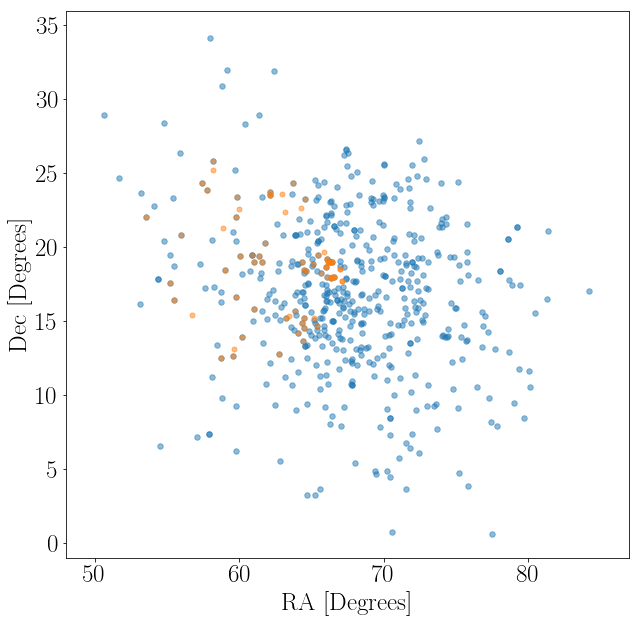

In [266]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(douglas.ra, douglas.dec, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

48 matches


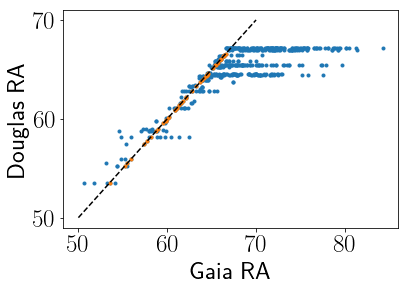

In [270]:
plt.plot(hg.RA_ICRS.values, closest_ra, ".")
#m = abs(hg.RA_ICRS.values - closest_ra) < 1./60
#m = distance < 5./3600  # Five arcseconds
print(sum(m), "matches")
plt.plot(hg.RA_ICRS.values[m], closest_ra[m], ".")
plt.xlabel("Gaia RA")
plt.ylabel("Douglas RA")
xs = np.linspace(50, 70, 100)
plt.plot(xs, xs, "--k")

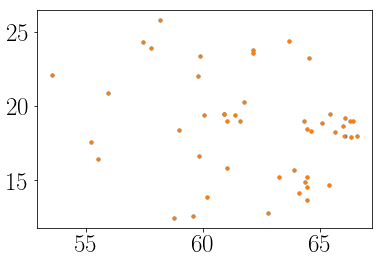

In [269]:
plt.plot(hg.RA_ICRS[m], hg.DE_ICRS[m], ".", label="Gaia")
plt.plot(closest_ra[m], closest_dec[m], ".", label="Douglas")

In [ ]:
hg_doug = hg.iloc[m]
douglas_match = pd.merge(hg_doug, )

(-1, 36)

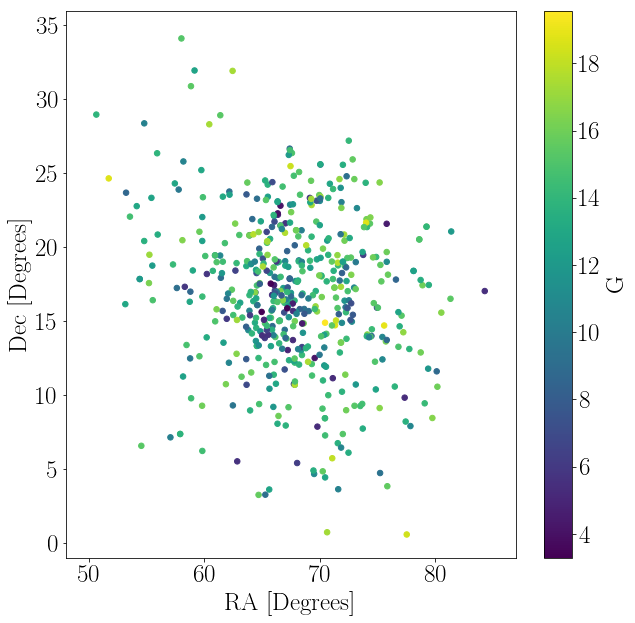

In [138]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, c=hg.Gmag)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.colorbar(label="$\mathrm{G}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)